In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mandates
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model

In [10]:
!pip install tensorflow
!pip install tensorflow-addons
!pip install pydot
!pip install pydotplus
!pip install tensorflow-model-optimization
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import plot_model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 4.2 MB/s eta 0:00:00


In [12]:
df = pd.read_csv('/content/data.csv', na_values=['null'], index_col='Date', parse_dates=True, infer_datetime_format=True)

In [13]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-22,0.437500,0.488281,0.388021,0.410156,0.376358,271468800
1999-01-25,0.442708,0.458333,0.410156,0.453125,0.415786,51048000
1999-01-26,0.458333,0.467448,0.411458,0.417969,0.383527,34320000
1999-01-27,0.419271,0.429688,0.395833,0.416667,0.382332,24436800
1999-01-28,0.416667,0.419271,0.412760,0.415365,0.381137,22752000


In [14]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-22,0.437500,0.488281,0.388021,0.410156,0.376358,271468800
1999-01-25,0.442708,0.458333,0.410156,0.453125,0.415786,51048000
1999-01-26,0.458333,0.467448,0.411458,0.417969,0.383527,34320000
1999-01-27,0.419271,0.429688,0.395833,0.416667,0.382332,24436800
1999-01-28,0.416667,0.419271,0.412760,0.415365,0.381137,22752000


In [17]:
df.isnull().values.any()

False

In [18]:
df.fillna(df.mean(), inplace=True)

In [19]:
df.isnull().values.any()

False

In [20]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

<Axes: xlabel='Date'>

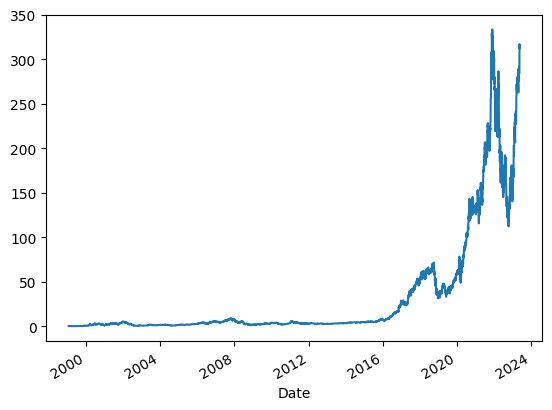

In [21]:
df['Adj Close'].plot()

In [22]:
# Value of the stock at the end of the day to predict
predict = pd.DataFrame(df['Adj Close'])

# Features to use to predict the value of the stock
features = ['Open', 'High', 'Low', 'Volume']

In [23]:
scaler = MinMaxScaler()
features_normalised = scaler.fit_transform(df[features])
features_normalised = pd.DataFrame(columns=features, data=features_normalised, index=df.index)
features_normalised.head()

,Open,High,Low,Volume
Date,,,,
1999-01-22,0.000264,0.000384,0.000171,0.292580
1999-01-25,0.000280,0.000297,0.000240,0.053283
1999-01-26,0.000327,0.000324,0.000244,0.035123
1999-01-27,0.000210,0.000214,0.000195,0.024393
1999-01-28,0.000202,0.000184,0.000248,0.022564


In [25]:
timesplit = TimeSeriesSplit(n_splits=10)

for training_index, test_index in timesplit.split(features_normalised):
    X_train, X_test = features_normalised[:len(training_index)], features_normalised[len(training_index): (len(training_index)+len(test_index))]
    y_train, y_test = predict[:len(training_index)].values.ravel(), predict[len(training_index): (len(training_index)+len(test_index))].values.ravel()

In [26]:
train_X = np.array(X_train)
test_X = np.array(X_test)

X_train = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
X_test = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

In [27]:
lstm = Sequential()
lstm.add(LSTM(128, activation='relu', input_shape=(1, train_X.shape[1]), return_sequences=False))
lstm.add(Dense(1))
lstm.compile(optimizer='adam', loss='mse')

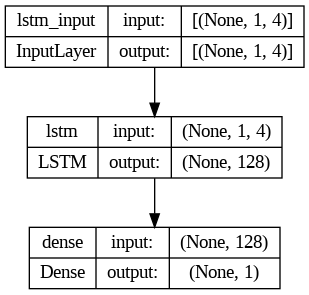

In [28]:
plot_model(lstm, show_shapes=True, show_layer_names=True)

In [29]:
history = lstm.fit(X_train, y_train, epochs=100, batch_size=16, shuffle=False, verbose=1)

Epoch 1/100
348/348 [==============================] - 4s 6ms/step - loss: 605.7571
Epoch 2/100
348/348 [==============================] - 2s 4ms/step - loss: 520.2824
Epoch 3/100
348/348 [==============================] - 2s 7ms/step - loss: 443.2985
Epoch 4/100
348/348 [==============================] - 1s 4ms/step - loss: 399.1983
Epoch 5/100
348/348 [==============================] - 1s 4ms/step - loss: 352.7987
Epoch 6/100
348/348 [==============================] - 1s 3ms/step - loss: 302.6806
Epoch 7/100
348/348 [==============================] - 2s 5ms/step - loss: 248.9676
Epoch 8/100
348/348 [==============================] - 2s 6ms/step - loss: 191.5546
Epoch 9/100
348/348 [==============================] - 2s 6ms/step - loss: 133.0535
Epoch 10/100
348/348 [==============================] - 1s 4ms/step - loss: 81.0714
Epoch 11/100
348/348 [==============================] - 2s 6ms/step - loss: 43.5525
Epoch 12/100
348/348 [==============================] - 2s 4ms/step - loss: 

In [30]:
y_pred = lstm.predict(X_test)

18/18 [==============================] - 0s 3ms/step


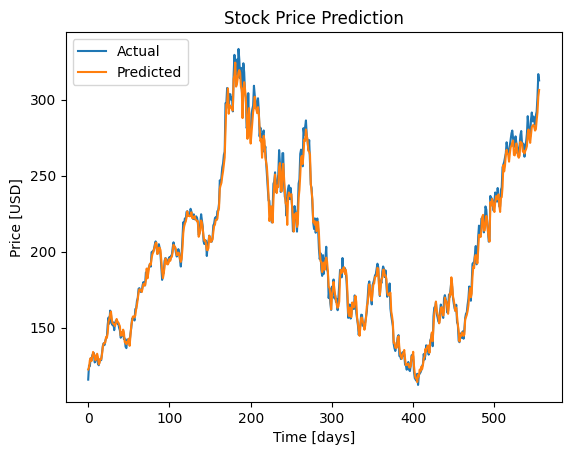

In [31]:
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Stock Price Prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price [USD]')
plt.legend()
plt.show()